In [1]:
import numpy as np
import scipy as sp
from scipy import integrate
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from lanczos_bin import *

from IPython.display import clear_output
%load_ext autoreload
%autoreload 2

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Setup

In [3]:
n = 50
lam = model_problem_spectrum(n,.8,1e3).astype(np.longdouble)
b = np.ones(n,dtype=np.longdouble)
b /= np.linalg.norm(b)

lmin = np.min(lam).astype(np.double)
lmax = np.max(lam).astype(np.double)
kappa = lmax / lmin

In [4]:
w = 0

# norm to measure function approximation and linear system errors
B = lam**2#np.ones(n)


In [5]:
K = 100
Q,(a_,b_) = exact_lanczos(lam.astype(np.single),b.astype(np.single),K+1,reorth=False)

K_exact = 40
Q_exact,(a_exact,b_exact) = exact_lanczos(lam,b,K_exact+1,reorth=True)

In [6]:
T = np.diag(a_).astype(np.double) + np.diag(b_,1).astype(np.double) + np.diag(b_,-1).astype(np.double)
F_roundoff = np.diag(lam)@Q.astype(np.double) - Q.astype(np.double)@T.astype(np.double)

In [7]:
plot_tol = 1e-20

In [8]:
T = np.zeros((3,K+1),dtype=np.double)
T[0,1:] = b_
T[1] = a_-w
T[2,:-1] = b_

e1 = np.zeros(K+1)
e1[0] = 1

In [9]:
err_CG = np.full(K,np.nan)

for k in range(0,K):
    try:
        e = (1/(lam-w))*b - np.linalg.norm(b)*Q[:,:k+1]@sp.linalg.solve_banded((1,1),T[:,:k+1],e1[:k+1])
        err_CG[k] = np.sqrt( e.T*B@e )
    except: pass
    
    if err_CG[k] < plot_tol:
        break

In [10]:
res_CG = np.full(K,np.nan)

for k in range(0,K):
    try:
        r = b - np.linalg.norm(b)*(lam-w)*(Q[:,:k+1]@sp.linalg.solve_banded((1,1),T[:,:k+1],e1[:k+1]))
        res_CG[k] = np.sqrt( r@r )
    except: pass
    
    if res_CG[k] < plot_tol:
        break

## $f(x) = 1/\sqrt{x}$, $\Gamma =$ circle

In [11]:
def f(x):
    return np.sqrt(x)

fAb = f(lam)*b

In [12]:
err_lanczos = np.full(K,np.nan)

for k in range(0,K):
    try:
        e = fAb - lanczos_FA(f,Q[:,:k+1].astype(np.double),a_[:k+1].astype(np.double),b_[:k].astype(np.double),normb=np.linalg.norm(b))
        err_lanczos[k] = np.sqrt( e.T*B@e )
    except: pass
    
    if err_lanczos[k] < plot_tol:
        break

In [13]:
err_lanczos_exact = np.full(K,np.nan)

for k in range(0,K_exact):
    try:
        e = fAb - lanczos_FA(f,Q_exact[:,:k+1],a_exact[:k+1],b_exact[:k],normb=np.linalg.norm(b))
        err_lanczos_exact[k] = np.sqrt( e.T*B@e )
    except: pass
    
    if err_lanczos_exact[k] < plot_tol:
        break

In [14]:
def Gamma(t):
    z = lmin/100 + np.exp((np.pi-np.pi/100)*1j)*t
    dz = np.exp((np.pi-np.pi/100)*1j)
    
    return z,dz

In [15]:
a_priori_bound_circle = np.full(K,np.inf)
a_posteriori_bound_circle = np.full(K,np.inf)

for k in range(1,K):
    a_priori_bound_circle[k-1] = 2*get_a_priori_bound(f,Gamma,[0,np.inf],k,w,lmin,lmax)[0]
    a_posteriori_bound_circle[k-1] = 2*get_a_posteriori_bound(f,Gamma,[0,np.inf],a_[:k],b_[:k-1],w,lmin,lmax)[0]

/home/tyler/Documents/GitHub/Research_Code/lanczos_function_CIF/lanczos_bin/lanczos.py:205: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral = sp.integrate.quad(F,endpts[0],endpts[1],epsabs=0,limit=200)


In [16]:
f_norms_full = np.full(K,np.nan)

for k in range(1,K):
    theta = sp.linalg.eigvalsh_tridiagonal(a_[:k].astype(np.double),b_[:k-1].astype(np.double),tol=1e-30)

    e1 = np.zeros(k,dtype='complex')
    e1[0] = 1
    
    T = np.zeros((3,k),dtype='complex')
    T[0,:-1] = b_[:k-1]
    T[1] = a_[:k] - w
    T[2,1:] = b_[:k-1]
    
    Twinve1 = sp.linalg.solve_banded((1, 1), T, e1)
    
    def F(t):

        z,dz = Gamma(t)
        
        T[1] = a_[:k] - z

        Tzinve1 = sp.linalg.solve_banded((1, 1), T, e1)

        fk = F_roundoff[:,:k]@ (Tzinve1 - np.prod((theta-w)/(theta-z)) * Twinve1)
        
        return (1/(2*np.pi)) * np.abs(f(z)) * Q_wz(w,z,lmin,lmax) * np.linalg.norm(fk) * np.abs(dz)
        
    integral = sp.integrate.quad(F,0,np.inf,epsabs=0,limit=200) 
    
    f_norms_full[k-1] = 2*integral[0]


<ipython-input-16-acd74639c1d4>:28: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral = sp.integrate.quad(F,0,np.inf,epsabs=0,limit=200)
<ipython-input-16-acd74639c1d4>:28: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  integral = sp.integrate.quad(F,0,np.inf,epsabs=0,limit=200)


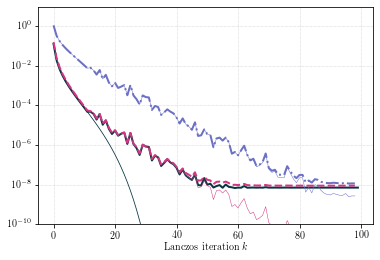

In [17]:
plt.figure(figsize=(6,4))


plt.plot(err_lanczos_exact,linestyle='-',lw=.8,color='#073642')
plt.plot(err_lanczos,linestyle='-',linewidth=2,color='#073642')


plt.plot(a_priori_bound_circle*err_CG+f_norms_full,linestyle='-.',linewidth=2,color='#6c71c4')
plt.plot(a_posteriori_bound_circle*err_CG+f_norms_full,linestyle='--',linewidth=2,color='#d33682')

plt.plot(a_priori_bound_circle*err_CG,linestyle='-',linewidth=.5,color='#6c71c4')
plt.plot(a_posteriori_bound_circle*err_CG,linestyle='-',linewidth=.5,color='#d33682')

plt.yscale('log')

legend_elements = [Line2D([0],[0],linestyle='-',color='#073642',label='$\| f(\mathbf{{A}})\mathbf{{b}} - \\textsf{lan}_k(f) \|_{(\\mathbf{A}-w\\mathbf{I})^2}$ (fp)'),
                   Line2D([0],[0],linestyle='-',lw=.8,color='#073642',label='$\| f(\mathbf{{A}})\mathbf{{b}} - \\textsf{lan}_k(f) \|_{(\\mathbf{A}-w\\mathbf{I})^2}$'),

                   Line2D([0],[0],linestyle='--',linewidth=2,color='#d33682',label='$(\\textrm{B1}) \: \| \\textsf{res}_k(w) \|_2$'),
                   Line2D([0],[0],linestyle='-',linewidth=.5,color='#d33682',label='$(\\textrm{B1}) \: \| \\textsf{res}_k(w) \|_2+(\\textrm{FP})$'),
                   Line2D([0],[0],linestyle='-.',linewidth=2,color='#6c71c4',label='$(\\textrm{B2}) \: \| \\textsf{res}_k(w) \|_2$'),
                   Line2D([0],[0],linestyle='-',linewidth=.5,color='#6c71c4',label='$(\\textrm{B2}) \: \| \\textsf{res}_k(w) \|_2+(\\textrm{FP})$'),
  
#                   Line2D([0],[0],linestyle='-',linewidth=1,color='#073642',label='$\\exp(-2k/\\sqrt{\\kappa(\\mathbf{A}-w\\mathbf{I})})$')
                  ]

#plt.legend(handles=legend_elements,loc='upper right')

#plt.plot(a_priori_bound_circle*2*(1/lmin)*np.linalg.norm(np.sqrt(B)*b)*(( np.sqrt(kappa) - 1 )/( np.sqrt(kappa) + 1 ))**np.arange(K),linestyle=':',linewidth=1,color='#073642')

#for c in range(-12,4,3):
#    plt.plot(10**(c)*(( np.sqrt(kappa) - 1 )/( np.sqrt(kappa) + 1 ))**np.arange(K),linestyle=':',linewidth=.5,color='#073642')

plt.ylim(1e-10,1e1)

plt.grid(True,linestyle=':',linewidth=.5)


#plt.title('$(\\mathbf{A}-w\\mathbf{I})^2$-norm error bounds: $f(x) = \\sqrt{x}$')
plt.xlabel('Lanczos iteration $k$')

plt.savefig('imgs/sqrt_AwI2norm_fp.pdf',bbox_inches='tight')

In [18]:
F_norms = np.full(K,np.nan)
F_col_norms = np.full(K,np.nan)
orth_norms = np.full(K,np.nan)

for k in range(1,K):
    F_norms[k-1] = np.linalg.norm(F_roundoff[:,:k+1].astype(np.double),ord='fro')
    F_col_norms[k-1] = np.linalg.norm(F_roundoff[:,k+1].astype(np.double))

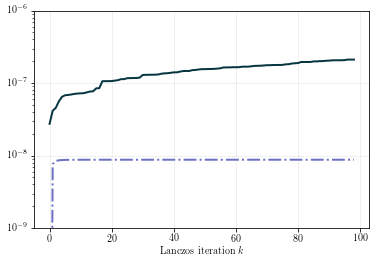

In [19]:
plt.figure(figsize=(6,4))

plt.plot(F_norms,linestyle='-',linewidth=2,color='#073642')
#plt.plot(np.linalg.norm(F_roundoff,axis=0)[:-1],linestyle='--',color='#d33682')
plt.plot(f_norms_full,linestyle='-.',linewidth=2,color='#6c71c4')
#plt.plot(f_norms_simple,linestyle='--',color='#d33682')

plt.yscale('log')

legend_elements = [Line2D([0],[0],linestyle='-',color='#073642',label='$\| \\mathbf{{F}}_k \|_{{\\footnotesize\\textsf{{F}}}}$'),

                   Line2D([0],[0],linestyle='--',color='#d33682',label='$\| [\\mathbf{{F}}_k]_{:,k} \|_2$'),
                   Line2D([0],[0],linestyle='-.',color='#6c71c4',label='(FP)'),                  
                  ]

#plt.legend(handles=legend_elements,loc='upper right')

plt.ylim([1e-9,1e-6])

plt.grid(True,linestyle=':',linewidth=.5)

#plt.title(f'finite precision quantities')
plt.xlabel('Lanczos iteration $k$')

plt.savefig('imgs/sqrt_CIF_fp_quantities.pdf',bbox_inches='tight')